In [1]:
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from nltk.stem.porter import PorterStemmer
from nltk.util import ngrams
from nltk.tokenize import word_tokenize, regexp_tokenize
import numpy as np
import spacy
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from gensim.models import Word2Vec

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Configurações gerais
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# 1. CARREGAR OS DADOS

In [3]:
chunksize = 100000  # Processar em lotes de 100.000 linhas
data_chunks = []
for chunk in pd.read_csv('complaints.csv', chunksize=chunksize):
    chunk = chunk.dropna()
    data_chunks.append(chunk)
data = pd.concat(data_chunks, ignore_index=True)

## 1.1 Balancear (10.000 exemplos p/ classe)

In [4]:
n_samples_per_class = 10000
classes = data["product_5"].unique()
balanced_data = []

for class_name in classes:
    class_data = data[data["product_5"] == class_name]
    class_sample = class_data.sample(n=n_samples_per_class, random_state=42)
    balanced_data.append(class_sample)

In [5]:
# Concatenar os dados balanceados
data_balanced = pd.concat(balanced_data, ignore_index=True)
print("\nDistribuição das classes após seleção balanceada:")
print(data_balanced["product_5"].value_counts())


Distribuição das classes após seleção balanceada:
product_5
Credit Reporting              10000
Debt Collection               10000
Loans                         10000
Bank Accounts and Services    10000
Credit Card Services          10000
Name: count, dtype: int64


In [6]:
# Guardar uma reclamação pequena
complaint_index = None
for complaint_index in range(50):
    example_complaint = data["narrative"].iloc[complaint_index]
    if len(example_complaint) < 150:
        print("Tamanho da reclamação:", len(example_complaint), " palavras.")
        print("Classe:", data["product_5"].iloc[complaint_index])
        print("Reclamação: '\n", example_complaint, "'.")
        break

Tamanho da reclamação: 90  palavras.
Classe: Credit Reporting
Reclamação: '
 I was reviewing my consumer report and noticed these inquiries that does not belong to me. '.


# 2. PRÉ-PROCESSAMENTO

In [7]:
ps = PorterStemmer()
nlp = spacy.load("en_core_web_sm")
sw = set(stopwords.words("english"))

In [8]:
REGEX_PATTERN = r'''(?x)  # Retirado do Notebook do Professor "preprocessing.ipynb"
    (?:[A-Z]\.)+         
    | (?!x+\b)\w+(?:-\w+)*  # Exclui palavras só com "x"
    | \$?\d+(?:\.\d+)?%? 
    | \.\.\.             
    | [][.,;"'?():-_`]  
'''

In [9]:
def preprocess_stemming(text):
    tokens = regexp_tokenize(str(text).lower(), REGEX_PATTERN)
    tokens = [ps.stem(w) for w in tokens if w not in sw]
    return ' '.join(tokens)

def preprocess_lemmatization(text):
    tokens = regexp_tokenize(str(text).lower(), REGEX_PATTERN)
    doc = nlp(' '.join(tokens))
    tokens = [token.lemma_ for token in doc if token.text not in sw and token.is_alpha]
    return ' '.join(tokens)

In [10]:
# Dicionário com as configurações de pré-processamento de forma a verificar resultados
preprocessing_configs = {
    "stemming": (preprocess_stemming, "consumer_complaints_stem_50000.csv", "processed_text_stem"),
    "lemmatization": (preprocess_lemmatization, "consumer_complaints_lem_50000.csv", "processed_text_lem")
}

In [11]:
# Aplicar pré-processamento para cada configuração
for config_name, (preprocess_func, file_name, column_name) in preprocessing_configs.items():
    corpus = [preprocess_func(review) for review in data_balanced["narrative"]]
    data_balanced[column_name] = corpus

In [12]:
comparison_data = {
    "Original": word_tokenize(example_complaint.lower()),
    "Stemming": preprocess_stemming(example_complaint).split(),
    "Lemmatization": preprocess_lemmatization(example_complaint).split()
}

In [13]:
# Ajustar comprimentos para o DataFrame
max_len = max(len(tokens) for tokens in comparison_data.values())
for key in comparison_data:
    comparison_data[key] += [''] * (max_len - len(comparison_data[key]))

comparison_df = pd.DataFrame(comparison_data)
print("\nComparação entre Stemming e Lemmatization:")
print(comparison_df)


Comparação entre Stemming e Lemmatization:
     Original Stemming Lemmatization
0           i   review        review
1         was   consum      consumer
2   reviewing   report        report
3          my    notic        notice
4    consumer  inquiri       inquiry
5      report   belong        belong
6         and        .              
7     noticed                       
8       these                       
9   inquiries                       
10       that                       
11       does                       
12        not                       
13     belong                       
14         to                       
15         me                       
16          .                       


# 3. EDA (Para steeming e lemmatization)

In [14]:
# Função para realizar EDA num corpus
def perform_eda(corpus, config_name):
    
    # a) Comprimento das reclamações
    word_counts = corpus.apply(lambda x: len(str(x).split()))  # Split simples, pois o corpus já está tokenizado
    print("\nEstatísticas do Comprimento das Reclamações:")
    print(word_counts.describe())
    
    # Histograma com ajuste do eixo X
    plt.figure()
    sns.histplot(word_counts, bins=50, kde=True)
    plt.title(f"Distribuição do Comprimento das Reclamações ({config_name})")
    plt.xlabel("Número de Palavras")
    plt.ylabel("Frequência")
    xlim_max = word_counts.quantile(0.99)
    plt.xlim(0, xlim_max)
    plt.tight_layout()
    plt.savefig(f"word_count_distribution_{config_name.lower().replace(' ', '_')}.png")
    plt.show()
    
    # b) Análise de vocabulário com CountVectorizer
    vectorizer = CountVectorizer(max_features=20, stop_words=list(sw))
    X = vectorizer.fit_transform(corpus).toarray()
    vocab = vectorizer.get_feature_names_out()
    print(f"\nTop 20 Palavras no Vocabulário ({config_name}):")
    print(vocab)
    
    # c) N-gramas mais frequentes
    bigram_counts = Counter()
    batch_size = 10000
    for i in range(0, len(corpus), batch_size):
        batch_corpus = corpus[i:i + batch_size].astype(str).tolist()
        for doc in batch_corpus:
            tokens = doc.split()  # Tokens já estão stemmed ou lematizados
            bigrams = ngrams(tokens, 2)
            bigram_counts.update(bigrams)
    
    bigram_counts = bigram_counts.most_common(10)
    print(f"\nTop 10 Bigramas Mais Frequentes ({config_name}):")
    for bigram, count in bigram_counts:
        print(f"{' '.join(bigram)}: {count}")
    
    plt.figure()
    bigram_labels = [" ".join(bigram[0]) for bigram in bigram_counts]
    bigram_values = [bigram[1] for bigram in bigram_counts]
    sns.barplot(x=bigram_labels, y=bigram_values)
    plt.title(f"Top 10 Bigramas Mais Frequentes ({config_name})")
    plt.xlabel("Bigrama")
    plt.ylabel("Frequência")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.savefig(f"top_bigrams_{config_name.lower().replace(' ', '_')}.png")
    plt.show()
    
    return sw

In [15]:
eda_results = {}

### 3.1 Executar EDA para lemmatização


Estatísticas do Comprimento das Reclamações:
count    50000.000000
mean        88.824440
std        107.606569
min          0.000000
25%         30.000000
50%         59.000000
75%        109.000000
max       3608.000000
Name: processed_text_lem, dtype: float64


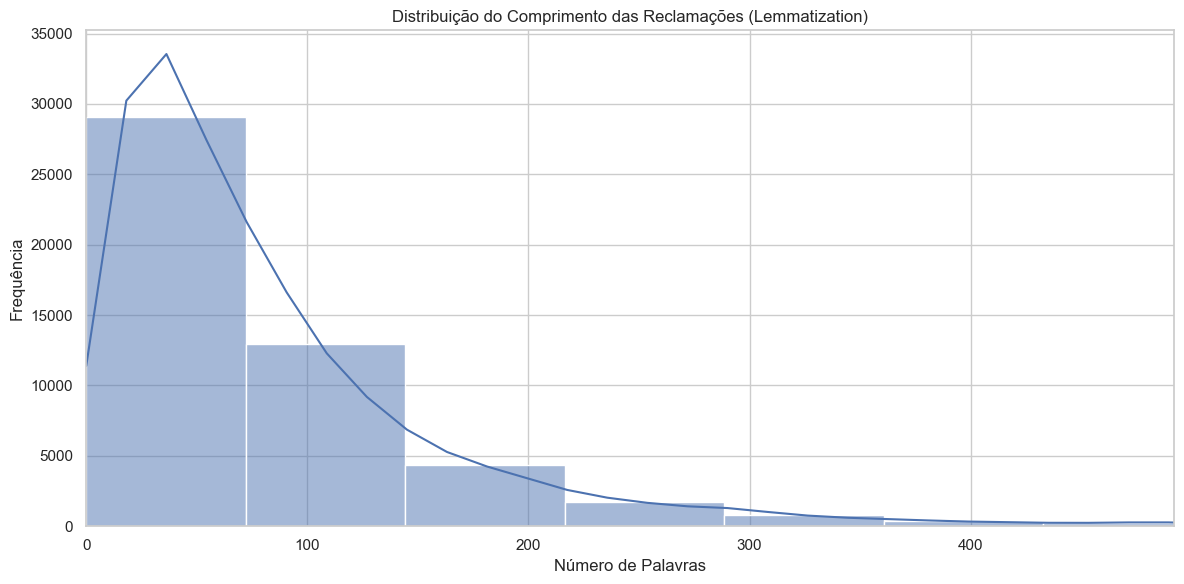


Top 20 Palavras no Vocabulário (Lemmatization):
['account' 'bank' 'call' 'card' 'charge' 'credit' 'debt' 'get'
 'information' 'loan' 'make' 'pay' 'payment' 'receive' 'report' 'say'
 'send' 'tell' 'time' 'would']

Top 10 Bigramas Mais Frequentes (Lemmatization):
credit report: 17600
credit card: 12542
reporting agency: 6225
wells fargo: 5969
customer service: 5750
credit reporting: 5658
make payment: 5540
u c: 5224
capital one: 4846
consumer reporting: 4747


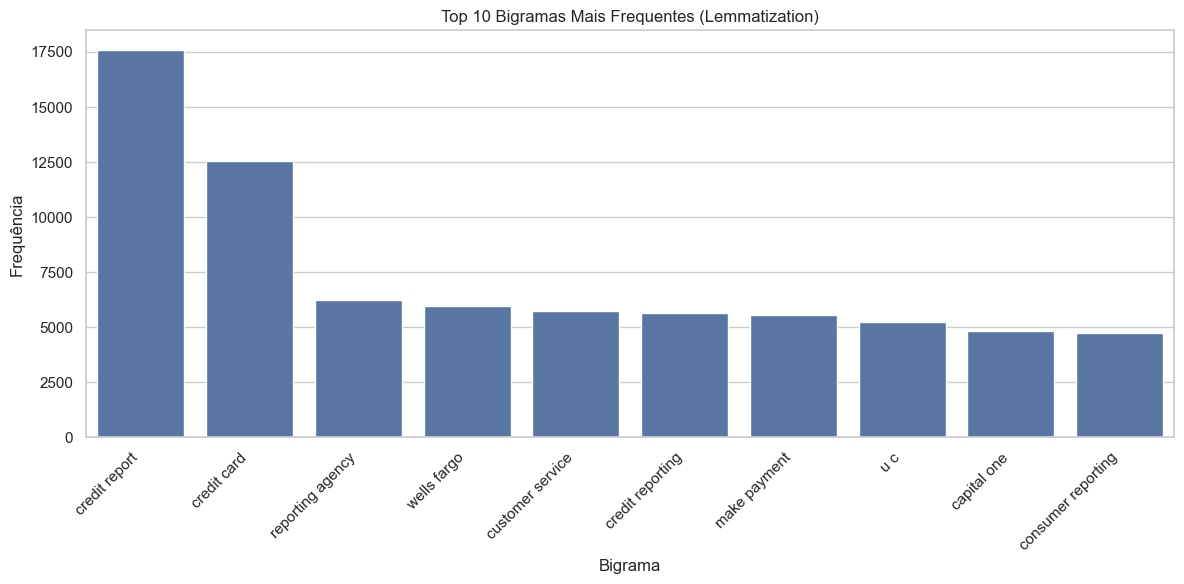

In [16]:
eda_results["Lemmatization"] = perform_eda(data_balanced["processed_text_lem"], "Lemmatization")

### 3.2 Executar EDA para Stemming


Estatísticas do Comprimento das Reclamações:
count    50000.000000
mean       112.424500
std        138.540453
min          0.000000
25%         38.000000
50%         75.000000
75%        137.000000
max       4579.000000
Name: processed_text_stem, dtype: float64


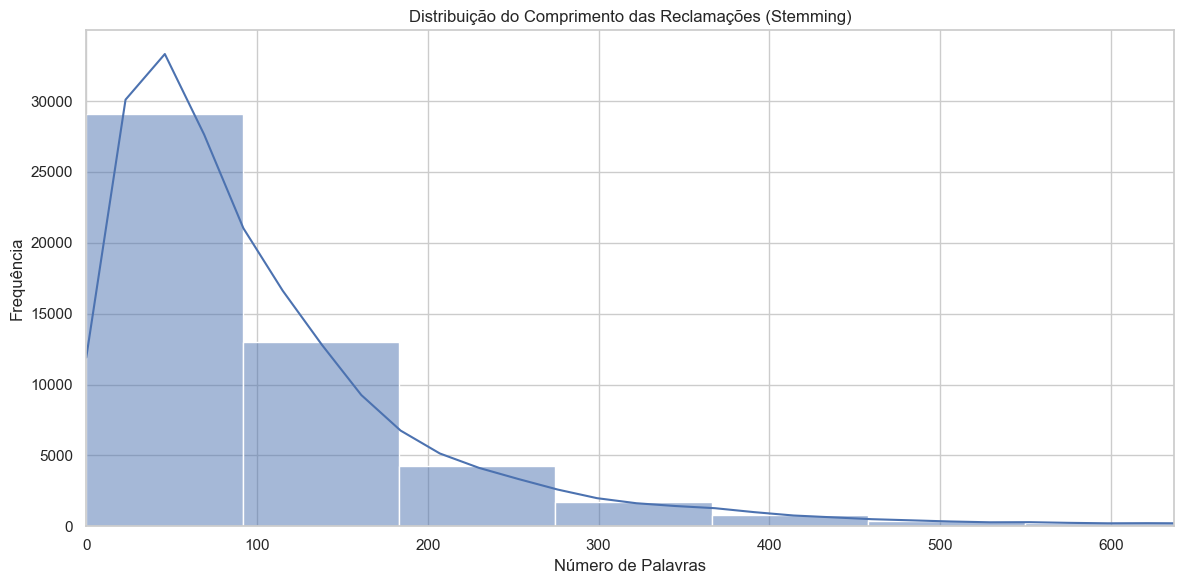


Top 20 Palavras no Vocabulário (Stemming):
['00' 'account' 'bank' 'call' 'card' 'charg' 'check' 'consum' 'credit'
 'day' 'debt' 'inform' 'loan' 'payment' 'receiv' 'report' 'state' 'time'
 'told' 'would']

Top 10 Bigramas Mais Frequentes (Stemming):
credit report: 23176
account .: 16705
( ): 14691
' ': 13633
credit card: 12521
. .: 12491
. call: 11922
, ,: 10593
report .: 10163
. ,: 9809


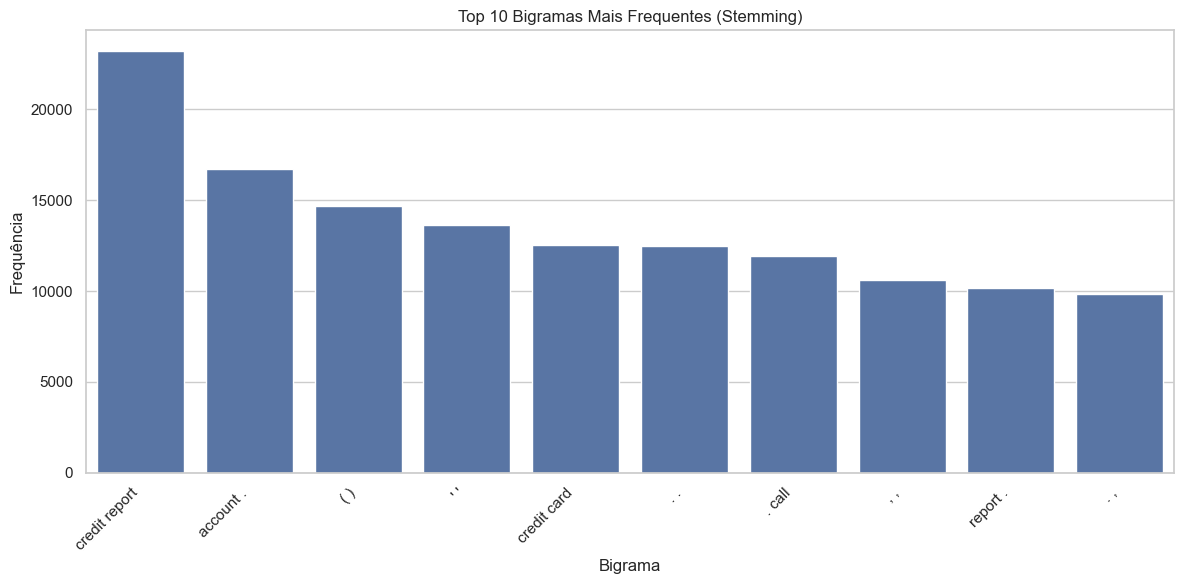

In [17]:
eda_results["Stemming"] = perform_eda(data_balanced["processed_text_stem"], "Stemming")

# 4. ENCONTRAR O MELHOR N-GRAMA

Com `Logistic Regression com L2` assumindo que esse será o melhor modelo.

In [18]:
ngram_ranges = [
    (1, 1),  # Apenas unigramas
    (1, 2),  # Unigramas e bigramas
    (1, 3),  # Unigramas, bigramas e trigramas
    (1, 4),  # Unigramas, bigramas, trigramas e quadrigramas
    (2, 2),  # Apenas bigramas
    (2, 3),  # Bigramas e trigramas
    (3, 3),  # Apenas trigramas
]

In [19]:
best_ngrams = {}

In [20]:
def find_best_ngram(config_name, column_name):
    ngram_results = []
    for ngram_range in ngram_ranges:
        tfidf = TfidfVectorizer(max_features=4000, ngram_range=ngram_range, stop_words=list(sw))
        X = tfidf.fit_transform(data_balanced[column_name])
        y = data_balanced["product_5"]
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        lr_l2 = LogisticRegression(penalty='l2', C=1.0, max_iter=1000, solver='liblinear')
        lr_l2.fit(X_train, y_train)
        y_pred = lr_l2.predict(X_test)
        
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
        
        ngram_results.append({
            "N-gram Range": ngram_range,
            "Accuracy": acc,
            "F1-score (macro)": f1
        })
    
    ngram_results_df = pd.DataFrame(ngram_results)
    print(f"\nResultados dos Testes de N-gramas para {config_name}:")
    print(ngram_results_df)
    
    best_ngram = ngram_results_df.loc[ngram_results_df["F1-score (macro)"].idxmax()]
    print(f"\nMelhor N-grama para {config_name}: {best_ngram['N-gram Range']}")
    print(f"Accuracy: {best_ngram['Accuracy']:.4f}")
    print(f"F1-score (macro): {best_ngram['F1-score (macro)']:.4f}")
    
    return best_ngram["N-gram Range"]

### 4.1 Encontrar o Melhor N-grama para Lemmatization

In [21]:
column_name = preprocessing_configs["lemmatization"][2]
best_ngrams["lemmatization"] = find_best_ngram("lemmatization", column_name)


Resultados dos Testes de N-gramas para lemmatization:
  N-gram Range  Accuracy  F1-score (macro)
0       (1, 1)    0.8536          0.853144
1       (1, 2)    0.8520          0.851529
2       (1, 3)    0.8516          0.851125
3       (1, 4)    0.8531          0.852673
4       (2, 2)    0.8054          0.804769
5       (2, 3)    0.8004          0.799829
6       (3, 3)    0.6463          0.650235

Melhor N-grama para lemmatization: (1, 1)
Accuracy: 0.8536
F1-score (macro): 0.8531


### 4.2 Encontrar o Melhor N-grama para Stemming

In [22]:
column_name = preprocessing_configs["stemming"][2]
best_ngrams["stemming"] = find_best_ngram("stemming", column_name)


Resultados dos Testes de N-gramas para stemming:
  N-gram Range  Accuracy  F1-score (macro)
0       (1, 1)    0.8516          0.851166
1       (1, 2)    0.8529          0.852461
2       (1, 3)    0.8528          0.852370
3       (1, 4)    0.8525          0.852067
4       (2, 2)    0.8052          0.804469
5       (2, 3)    0.8014          0.800620
6       (3, 3)    0.6495          0.653117

Melhor N-grama para stemming: (1, 2)
Accuracy: 0.8529
F1-score (macro): 0.8525


# Embedings (Glove)

In [23]:
def load_glove_embeddings(file_path):
    embeddings = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.strip().split()
            word = values[0]
            vector = np.array(values[1:], dtype='float32')
            embeddings[word] = vector
    print(f"Carregados {len(embeddings)} embeddings GloVe.")
    return embeddings

In [24]:
def glove_vectorize(corpus, glove_embeddings, embedding_dim=300):
    
    # Função interna para vetorizar um documento
    def document_vector(doc):
        words = doc.split()
        word_vectors = [glove_embeddings[word] for word in words if word in glove_embeddings]
        if len(word_vectors) == 0:
            return np.zeros(embedding_dim)  # Retorna vetor zerado se nenhuma palavra for encontrada
        return np.mean(word_vectors, axis=0)  # Média dos vetores das palavras
    
    # Vetorizar todos os documentos
    X_glove = np.array([document_vector(doc) for doc in corpus])
    print(f"Tamanho do espaço de features com GloVe: {X_glove.shape[1]} dimensões")
    
    return X_glove

In [26]:
glove_path = "glove.42B.300d.txt"  # Ajuste o caminho conforme necessário
glove_embeddings = load_glove_embeddings(glove_path)

Carregados 1917494 embeddings GloVe.


# 5. CLASSIFICADORES

In [27]:
def train_and_evaluate_classifiers(X, y, config_name, vectorizer_type, use_naive_bayes=True):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Naive Bayes (não funciona com embedings porque é só com esparsas)
    if use_naive_bayes:
        nb = MultinomialNB()
        nb.fit(X_train, y_train)
        y_pred_nb = nb.predict(X_test)
        print(f"Naive Bayes ({vectorizer_type}):\n", classification_report(y_test, y_pred_nb, zero_division=0))

    # Logistic Regression com L2
    lr_l2 = LogisticRegression(penalty='l2', max_iter=1000, solver='liblinear')
    lr_l2.fit(X_train, y_train)
    y_pred_lr_l2 = lr_l2.predict(X_test)
    print(f"Logistic Regression (L2) ({vectorizer_type}):\n", classification_report(y_test, y_pred_lr_l2, zero_division=0))
    print(f"Features ativas (L2): {(lr_l2.coef_ != 0).sum()}")

    # XGBoost
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    X_train, X_test, y_train_enc, y_test_enc = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

    xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
    xgb.fit(X_train, y_train_enc)
    y_pred_xgb = xgb.predict(X_test)
    y_pred_xgb_labels = le.inverse_transform(y_pred_xgb)
    print(f"XGBoost ({vectorizer_type}):\n", classification_report(y_test, y_pred_xgb_labels, zero_division=0))

## 5.1 CLASSIFICADORES COM LEMMATIZATION

In [28]:
config_name = "lemmatization"
column_name = preprocessing_configs[config_name][2]
best_ngram_range = best_ngrams[config_name]

### Bag-of-Words com CountVectorizer

In [29]:
vectorizer = CountVectorizer(max_features=4000, stop_words=list(sw))
X = vectorizer.fit_transform(data_balanced[column_name])
train_and_evaluate_classifiers(X, data_balanced["product_5"], config_name, "BoW")

Naive Bayes (BoW):
                             precision    recall  f1-score   support

Bank Accounts and Services       0.86      0.90      0.88      1998
      Credit Card Services       0.80      0.76      0.78      1950
          Credit Reporting       0.72      0.81      0.76      2043
           Debt Collection       0.81      0.68      0.74      1993
                     Loans       0.84      0.86      0.85      2016

                  accuracy                           0.80     10000
                 macro avg       0.81      0.80      0.80     10000
              weighted avg       0.81      0.80      0.80     10000

Logistic Regression (L2) (BoW):
                             precision    recall  f1-score   support

Bank Accounts and Services       0.87      0.89      0.88      1998
      Credit Card Services       0.82      0.81      0.81      1950
          Credit Reporting       0.80      0.82      0.81      2043
           Debt Collection       0.80      0.78      0.79  

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:48:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost (BoW):
                             precision    recall  f1-score   support

Bank Accounts and Services       0.89      0.90      0.90      1998
      Credit Card Services       0.84      0.83      0.84      1950
          Credit Reporting       0.82      0.84      0.83      2043
           Debt Collection       0.82      0.80      0.81      1993
                     Loans       0.87      0.87      0.87      2016

                  accuracy                           0.85     10000
                 macro avg       0.85      0.85      0.85     10000
              weighted avg       0.85      0.85      0.85     10000



### TF-IDF com o Melhor N-grama

In [30]:
tfidf_ngrams = TfidfVectorizer(max_features=4000, ngram_range=best_ngram_range, stop_words=list(sw))
X_tfidf_ngrams = tfidf_ngrams.fit_transform(data_balanced[column_name])
train_and_evaluate_classifiers(X_tfidf_ngrams, data_balanced["product_5"], config_name, f"TFIDF_Ngrams_{best_ngram_range}")

Naive Bayes (TFIDF_Ngrams_(1, 1)):
                             precision    recall  f1-score   support

Bank Accounts and Services       0.84      0.92      0.87      1998
      Credit Card Services       0.80      0.77      0.79      1950
          Credit Reporting       0.76      0.80      0.78      2043
           Debt Collection       0.81      0.72      0.76      1993
                     Loans       0.86      0.86      0.86      2016

                  accuracy                           0.81     10000
                 macro avg       0.81      0.81      0.81     10000
              weighted avg       0.81      0.81      0.81     10000

Logistic Regression (L2) (TFIDF_Ngrams_(1, 1)):
                             precision    recall  f1-score   support

Bank Accounts and Services       0.88      0.92      0.90      1998
      Credit Card Services       0.85      0.83      0.84      1950
          Credit Reporting       0.82      0.83      0.82      2043
           Debt Collection 

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:48:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost (TFIDF_Ngrams_(1, 1)):
                             precision    recall  f1-score   support

Bank Accounts and Services       0.89      0.91      0.90      1998
      Credit Card Services       0.85      0.83      0.84      1950
          Credit Reporting       0.82      0.84      0.83      2043
           Debt Collection       0.83      0.81      0.82      1993
                     Loans       0.87      0.88      0.88      2016

                  accuracy                           0.85     10000
                 macro avg       0.85      0.85      0.85     10000
              weighted avg       0.85      0.85      0.85     10000



### TF-IDF com o Melhor N-grama e Normalização

In [31]:
scaler = StandardScaler(with_mean=False)
X_tfidf_ngrams_scaled = scaler.fit_transform(X_tfidf_ngrams)
train_and_evaluate_classifiers(X_tfidf_ngrams_scaled, data_balanced["product_5"], config_name, f"TFIDF_Ngrams_Scaled_{best_ngram_range}")

Naive Bayes (TFIDF_Ngrams_Scaled_(1, 1)):
                             precision    recall  f1-score   support

Bank Accounts and Services       0.76      0.86      0.81      1998
      Credit Card Services       0.72      0.69      0.70      1950
          Credit Reporting       0.75      0.76      0.75      2043
           Debt Collection       0.77      0.67      0.72      1993
                     Loans       0.81      0.83      0.82      2016

                  accuracy                           0.76     10000
                 macro avg       0.76      0.76      0.76     10000
              weighted avg       0.76      0.76      0.76     10000

Logistic Regression (L2) (TFIDF_Ngrams_Scaled_(1, 1)):
                             precision    recall  f1-score   support

Bank Accounts and Services       0.81      0.83      0.82      1998
      Credit Card Services       0.77      0.76      0.77      1950
          Credit Reporting       0.79      0.77      0.78      2043
           De

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:51:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost (TFIDF_Ngrams_Scaled_(1, 1)):
                             precision    recall  f1-score   support

Bank Accounts and Services       0.89      0.91      0.90      1998
      Credit Card Services       0.85      0.83      0.84      1950
          Credit Reporting       0.82      0.84      0.83      2043
           Debt Collection       0.83      0.81      0.82      1993
                     Loans       0.87      0.88      0.88      2016

                  accuracy                           0.85     10000
                 macro avg       0.85      0.85      0.85     10000
              weighted avg       0.85      0.85      0.85     10000



### Embedings Glove (representação densa)

In [32]:
X_glove = glove_vectorize(data_balanced[column_name], glove_embeddings)
train_and_evaluate_classifiers(X_glove, data_balanced["product_5"], config_name, "GloVe", use_naive_bayes=False)

Tamanho do espaço de features com GloVe: 300 dimensões
Logistic Regression (L2) (GloVe):
                             precision    recall  f1-score   support

Bank Accounts and Services       0.84      0.88      0.86      1998
      Credit Card Services       0.81      0.78      0.79      1950
          Credit Reporting       0.78      0.81      0.79      2043
           Debt Collection       0.82      0.75      0.78      1993
                     Loans       0.84      0.86      0.85      2016

                  accuracy                           0.82     10000
                 macro avg       0.82      0.82      0.82     10000
              weighted avg       0.82      0.82      0.82     10000

Features ativas (L2): 1500


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:55:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost (GloVe):
                             precision    recall  f1-score   support

Bank Accounts and Services       0.84      0.86      0.85      1998
      Credit Card Services       0.79      0.77      0.78      1950
          Credit Reporting       0.81      0.84      0.82      2043
           Debt Collection       0.80      0.78      0.79      1993
                     Loans       0.84      0.84      0.84      2016

                  accuracy                           0.82     10000
                 macro avg       0.82      0.82      0.82     10000
              weighted avg       0.82      0.82      0.82     10000



## 5.2 CLASSIFICADORES COM STEMMING

In [33]:
config_name = "stemming"
column_name = preprocessing_configs[config_name][2]
best_ngram_range = best_ngrams[config_name]

### Bag-of-Words com CountVectorizer

In [34]:
vectorizer = CountVectorizer(max_features=4000, stop_words=list(sw))
X = vectorizer.fit_transform(data_balanced[column_name])
train_and_evaluate_classifiers(X, data_balanced["product_5"], config_name, "BoW")

Naive Bayes (BoW):
                             precision    recall  f1-score   support

Bank Accounts and Services       0.85      0.90      0.88      1998
      Credit Card Services       0.79      0.75      0.77      1950
          Credit Reporting       0.71      0.81      0.76      2043
           Debt Collection       0.81      0.67      0.73      1993
                     Loans       0.84      0.86      0.85      2016

                  accuracy                           0.80     10000
                 macro avg       0.80      0.80      0.80     10000
              weighted avg       0.80      0.80      0.80     10000

Logistic Regression (L2) (BoW):
                             precision    recall  f1-score   support

Bank Accounts and Services       0.86      0.88      0.87      1998
      Credit Card Services       0.81      0.80      0.81      1950
          Credit Reporting       0.79      0.81      0.80      2043
           Debt Collection       0.79      0.78      0.78  

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:59:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost (BoW):
                             precision    recall  f1-score   support

Bank Accounts and Services       0.89      0.91      0.90      1998
      Credit Card Services       0.84      0.83      0.83      1950
          Credit Reporting       0.81      0.83      0.82      2043
           Debt Collection       0.83      0.79      0.81      1993
                     Loans       0.87      0.88      0.87      2016

                  accuracy                           0.85     10000
                 macro avg       0.85      0.85      0.85     10000
              weighted avg       0.85      0.85      0.85     10000



### TF-IDF com o Melhor N-grama

In [35]:
tfidf_ngrams = TfidfVectorizer(max_features=4000, ngram_range=best_ngram_range, stop_words=list(sw))
X_tfidf_ngrams = tfidf_ngrams.fit_transform(data_balanced[column_name])
train_and_evaluate_classifiers(X_tfidf_ngrams, data_balanced["product_5"], config_name, f"TFIDF_Ngrams_{best_ngram_range}")

Naive Bayes (TFIDF_Ngrams_(1, 2)):
                             precision    recall  f1-score   support

Bank Accounts and Services       0.84      0.94      0.89      1998
      Credit Card Services       0.82      0.79      0.80      1950
          Credit Reporting       0.78      0.78      0.78      2043
           Debt Collection       0.81      0.72      0.76      1993
                     Loans       0.84      0.87      0.86      2016

                  accuracy                           0.82     10000
                 macro avg       0.82      0.82      0.82     10000
              weighted avg       0.82      0.82      0.82     10000

Logistic Regression (L2) (TFIDF_Ngrams_(1, 2)):
                             precision    recall  f1-score   support

Bank Accounts and Services       0.89      0.92      0.90      1998
      Credit Card Services       0.85      0.83      0.84      1950
          Credit Reporting       0.81      0.83      0.82      2043
           Debt Collection 

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:00:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost (TFIDF_Ngrams_(1, 2)):
                             precision    recall  f1-score   support

Bank Accounts and Services       0.89      0.91      0.90      1998
      Credit Card Services       0.85      0.83      0.84      1950
          Credit Reporting       0.82      0.84      0.83      2043
           Debt Collection       0.83      0.80      0.81      1993
                     Loans       0.87      0.88      0.87      2016

                  accuracy                           0.85     10000
                 macro avg       0.85      0.85      0.85     10000
              weighted avg       0.85      0.85      0.85     10000



### TF-IDF com o Melhor N-grama e Normalização

In [36]:
scaler = StandardScaler(with_mean=False)
X_tfidf_ngrams_scaled = scaler.fit_transform(X_tfidf_ngrams)
train_and_evaluate_classifiers(X_tfidf_ngrams_scaled, data_balanced["product_5"], config_name, f"TFIDF_Ngrams_Scaled_{best_ngram_range}")

Naive Bayes (TFIDF_Ngrams_Scaled_(1, 2)):
                             precision    recall  f1-score   support

Bank Accounts and Services       0.82      0.91      0.86      1998
      Credit Card Services       0.79      0.77      0.78      1950
          Credit Reporting       0.79      0.74      0.76      2043
           Debt Collection       0.77      0.72      0.75      1993
                     Loans       0.82      0.86      0.84      2016

                  accuracy                           0.80     10000
                 macro avg       0.80      0.80      0.80     10000
              weighted avg       0.80      0.80      0.80     10000

Logistic Regression (L2) (TFIDF_Ngrams_Scaled_(1, 2)):
                             precision    recall  f1-score   support

Bank Accounts and Services       0.82      0.84      0.83      1998
      Credit Card Services       0.78      0.77      0.77      1950
          Credit Reporting       0.79      0.78      0.78      2043
           De

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:04:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost (TFIDF_Ngrams_Scaled_(1, 2)):
                             precision    recall  f1-score   support

Bank Accounts and Services       0.89      0.91      0.90      1998
      Credit Card Services       0.85      0.83      0.84      1950
          Credit Reporting       0.82      0.84      0.83      2043
           Debt Collection       0.83      0.80      0.81      1993
                     Loans       0.87      0.88      0.87      2016

                  accuracy                           0.85     10000
                 macro avg       0.85      0.85      0.85     10000
              weighted avg       0.85      0.85      0.85     10000



### Embedings Glove (representação densa)

In [37]:
X_glove = glove_vectorize(data_balanced[column_name], glove_embeddings)
train_and_evaluate_classifiers(X_glove, data_balanced["product_5"], config_name, "GloVe", use_naive_bayes=False)

Tamanho do espaço de features com GloVe: 300 dimensões
Logistic Regression (L2) (GloVe):
                             precision    recall  f1-score   support

Bank Accounts and Services       0.84      0.88      0.86      1998
      Credit Card Services       0.80      0.77      0.79      1950
          Credit Reporting       0.77      0.79      0.78      2043
           Debt Collection       0.81      0.73      0.77      1993
                     Loans       0.82      0.86      0.84      2016

                  accuracy                           0.81     10000
                 macro avg       0.81      0.81      0.81     10000
              weighted avg       0.81      0.81      0.81     10000

Features ativas (L2): 1500


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:09:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost (GloVe):
                             precision    recall  f1-score   support

Bank Accounts and Services       0.84      0.85      0.85      1998
      Credit Card Services       0.79      0.77      0.78      1950
          Credit Reporting       0.79      0.82      0.80      2043
           Debt Collection       0.78      0.75      0.77      1993
                     Loans       0.83      0.83      0.83      2016

                  accuracy                           0.81     10000
                 macro avg       0.81      0.81      0.81     10000
              weighted avg       0.81      0.81      0.81     10000

